In [12]:
import pandas as pd

In [13]:
PATH = "gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_5x_en_fixed_browser"
DATA_FILE = f"{PATH}/samples.jsonl"

In [14]:
# fix samples
ORIGINAL_TRAJECTORIES = pd.read_json(DATA_FILE, lines=True)
FIXED_TRAJECTORIES = ORIGINAL_TRAJECTORIES.copy()
FIXED_TRAJECTORIES["eval_task_id"] = FIXED_TRAJECTORIES["eval_task_id"].str.replace(r"-2$", "", regex=True)

In [15]:
FIXED_TRAJECTORIES.to_json(f"{PATH}/samples_fixed.jsonl", orient="records", lines=True)

In [16]:
FIXED_TRAJECTORIES = pd.read_json(f"{PATH}/samples_fixed.jsonl", lines=True)

In [17]:
import pandas as pd
import numpy as np

def expand_with_sliding_windows(df: pd.DataFrame, width: int,
                                length_col: str = "trajectory_length") -> pd.DataFrame:
    """
    For every row in *df*, create (trajectory_length – width + 1) copies,
    one for every sliding window of size *width*.
    Adds two new columns:  `window_start` and `window_end` (inclusive).
    Rows whose `trajectory_length` < width are silently dropped.

    Parameters
    ----------
    df : pd.DataFrame                 Original data.
    width : int                       Size of the sliding window.
    length_col : str, default 'trajectory_length'
                                      Column holding the total length.

    Returns
    -------
    pd.DataFrame                      Expanded frame.
    """
    if width <= 0:
        raise ValueError("width must be a positive integer")

    # how many windows each row will produce
    n_windows = df[length_col] - width + 1

    # keep only rows where at least one window fits
    valid_mask = n_windows > 0
    df_valid   = df[valid_mask].copy()
    n_windows  = n_windows[valid_mask]

    # repeat the rows the right number of times
    expanded = df_valid.loc[df_valid.index.repeat(n_windows)].reset_index(drop=True)

    # build the window start indices in one NumPy shot
    starts = np.concatenate([np.arange(k) for k in n_windows])
    expanded["image_turns_start"] = starts
    expanded["image_turns_end"]   = starts + width        # inclusive upper bound
    expanded["text_turns_start"] = 0
    expanded["text_turns_end"]   = starts + width

    return expanded

In [22]:
FIXED_TRAJECTORIES

,eval_task_id,attempt_id,instruction,reward,output_folder,trajectory_length
0,2ad9387a-65d8-4e33-ad5b-7580065a27ca,c3daf13f1cb34ca9a735cd9e66378fd4,Can you make a new folder for me on the bookma...,0,gs://induction-labs-data-ext-mumbai/evals/test...,2
1,ce88f674-ab7a-43da-9201-468d38539e4a,4cd29b7218704f44be3606df73c9b3a1,Please set my slides upright instead of sideways.,0,gs://induction-labs-data-ext-mumbai/evals/test...,2
2,2cd43775-7085-45d8-89fa-9e35c0a915cf,373726d9a6a54ffab4c1705d11be15e6,"Enable auto-save every 3min for me, so that I ...",0,gs://induction-labs-data-ext-mumbai/evals/test...,2
3,3f28fe4f-5d9d-4994-a456-efd78cfae1a3,33192184178245709e43ade65349d05c,Set up a signature using my name and affiliati...,0,gs://induction-labs-data-ext-mumbai/evals/test...,2
4,b148e375-fe0b-4bec-90e7-38632b0d73c2,be66098c436c4fde9210af956e5370d5,Could you assist me in adding a new layer and ...,0,gs://induction-labs-data-ext-mumbai/evals/test...,2
...,...,...,...,...,...,...
1350,535364ea-05bd-46ea-9937-9f55c68507e8,55cbc75da9d048248ed8a6bcd0816683,Create two tables in a new sheet showing the t...,0.0,gs://induction-labs-data-ext-mumbai/evals/test...,97
1351,e2392362-125e-4f76-a2ee-524b183a3412,ba9d2bb7e815485dbf5137bc9492c028,I recently started using the famous personal a...,0.0,gs://induction-labs-data-ext-mumbai/evals/test...,101
1352,b52b40a5-ad70-4c53-b5b0-5650a8387052,47a8a1593c4e4bd0829411633332b9b6,"Could you help me merge all PDF files in the ""...",0.0,gs://induction-labs-data-ext-mumbai/evals/test...,98
1353,adf5e2c3-64c7-4644-b7b6-d2f0167927e7,723529122c004e7eae9c55d58fd063f7,"Help me adding ""Steinberg, F. M., Bearden, M. ...",0,gs://induction-labs-data-ext-mumbai/evals/test...,101


In [27]:
CORRECT_TRAJECTORIES_EXPANDED = FIXED_TRAJECTORIES.copy()
CORRECT_TRAJECTORIES_EXPANDED = CORRECT_TRAJECTORIES_EXPANDED[CORRECT_TRAJECTORIES_EXPANDED["reward"] == 1]
CORRECT_TRAJECTORIES_EXPANDED = expand_with_sliding_windows(
    CORRECT_TRAJECTORIES_EXPANDED,
    width=5,
    length_col="trajectory_length"
)
num = 20
CORRECT_TRAJECTORIES_EXPANDED = CORRECT_TRAJECTORIES_EXPANDED[CORRECT_TRAJECTORIES_EXPANDED["text_turns_end"] <= num]
CORRECT_TRAJECTORIES_EXPANDED.to_json(f"{PATH}/samples_correct_trajectories_expanded_under_{num}.jsonl", orient="records", lines=True)

In [ ]:
shuffled = CORRECT_TRAJECTORIES_EXPANDED.sample(frac=1, random_state=248239)
test_size = 64
train_size = len(shuffled) - test_size
TRAIN_SET = shuffled.iloc[:train_size]
TEST_SET = shuffled.iloc[train_size:]

TRAIN_SET.to_json(f"{PATH}/samples_correct_trajectories_expanded_under_{num}_train.jsonl", orient="records", lines=True)
TEST_SET.to_json(f"{PATH}/samples_correct_trajectories_expanded_under_{num}_test.jsonl", orient="records", lines=True)

In [2]:
all_trajectories = pd.read_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples.jsonl", lines=True)

In [66]:
all_trajectories = pd.read_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_corrected.jsonl", lines=True)

In [67]:
all_trajectories["reward"][all_trajectories["trajectory_length"] > 20] = 0.0

/tmp/ipykernel_856279/3293495800.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  all_trajectories["reward"][all_trajectories["trajectory_length"] > 20] = 0.0
/tmp/ipykernel_856279/3293495800.py:1: SettingWithCopyWarning: 
A value is tryi

In [71]:
all_trajectories.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_corrected_cutoff_20.jsonl", lines=True, orient="records")

In [70]:
(all_trajectories["reward"] == 1).sum()

np.int64(973)

In [65]:
all_trajectories["eval_task_id"] = all_trajectories["eval_task_id"].str.replace(r"-2$", "", regex=True)
all_trajectories.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_corrected.jsonl", orient="records", lines=True)

In [19]:
correct_samples = all_trajectories[all_trajectories["reward"] == 1]
# correct_samples.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct.jsonl", orient="records", lines=True)

In [20]:
correct_samples

,eval_task_id,attempt_id,instruction,reward,output_folder,trajectory_length
0,3ef2b351-8a84-4ff2-8724-d86eae9b842e,ad6f99d3fdc94358880b2760a1d0da54,Help me center align the heading in LibreOffice.,1,gs://induction-labs-data-ext-mumbai/evals/test...,4
2,51b11269-2ca8-4b2a-9163-f21758420e78,b9e79fc5bb4146d5a8fd74ac3f400c7f,Could you help me to sort the records accoring...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,5
4,b148e375-fe0b-4bec-90e7-38632b0d73c2,a51cf8a924724a339d3956073858c402,Could you assist me in adding a new layer and ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,6
5,dd84e895-72fd-4023-a336-97689ded257c,fcb57957343b489f9e866d35fdc6f51f,Add a star to every email in local Bills folder,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,7
6,3a93cae4-ad3e-403e-8c12-65303b271818,c784e8cb8a95451fb07d863ede99a380,Could you please add a two-hour lecture slot t...,1,gs://induction-labs-data-ext-mumbai/evals/test...,6
...,...,...,...,...,...,...
4563,0810415c-bde4-4443-9047-d5f70165a697,f77e012c24f448e78f5edc40a83bfb06,Make the line spacing of first two paragraph i...,1,gs://induction-labs-data-ext-mumbai/evals/test...,10
4567,6e99a1ad-07d2-4b66-a1ce-ece6d99c20a5,da76094d3e0140de90a1b42a862fe757,"Help me format column ""spent"" by keeping two d...",1.0,gs://induction-labs-data-ext-mumbai/evals/test...,10
4568,7a4deb26-d57d-4ea9-9a73-630f66a7b568,ce1dcb8eb3e746bb816c48b7a6e1d66f,Could you tone down the brightness of my photo?,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,11
4575,8ba5ae7a-5ae5-4eab-9fcc-5dd4fe3abf89,1027967172a44cd8baca594de9e0febf,Help me modify the folder used to store my rec...,1,gs://induction-labs-data-ext-mumbai/evals/test...,9


In [30]:
# subtract one since there is a duplicate due to how the logger works
without_duplicate = correct_samples.copy()
without_duplicate["trajectory_length"] -= 1
expanded_turns = expand_with_sliding_windows(without_duplicate, width=5, length_col="trajectory_length")
expanded_turns["unmask_last_only"] = True

In [31]:
expanded_turns.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5.jsonl", orient="records", lines=True)

In [ ]:
import pandas as pd
expanded = pd.read_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5.jsonl", lines=True)

In [19]:
expanded["unmask_last_only"][expanded["image_turns_end"] <= 5] = False

/tmp/ipykernel_874041/1254394944.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  expanded["unmask_last_only"][expanded["image_turns_end"] <= 5] = False
/tmp/ipykernel_874041/1254394944.py:1: SettingWithCopyWarning: 
A value is trying to 

In [21]:
expanded.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5.jsonl", orient="records", lines=True)

In [22]:
from pickletools import TAKEN_FROM_ARGUMENT1


expanded[expanded["text_turns_end"] <= 20].to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5_under_20_turns.jsonl", lines=True, orient="records")

In [1]:
import pandas as pd
df = pd.read_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5_under_20_turns.jsonl", lines=True)

In [5]:
shuffled = df.sample(frac=1)
test_size = int(len(shuffled) * 0.02)
train = shuffled[:-test_size]
test = shuffled[-test_size:]

train.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5_under_20_turns_train.jsonl", lines=True, orient="records")
test.to_json("gs://induction-labs/jonathan/sampled_trajectories/osworld_uitars_10x_en_5k/samples_correct_expanded_5_under_20_turns_test.jsonl", lines=True, orient="records")

In [6]:
test

,eval_task_id,attempt_id,instruction,reward,output_folder,trajectory_length,image_turns_start,image_turns_end,text_turns_start,text_turns_end,unmask_last_only
3733,af23762e-2bfd-4a1d-aada-20fa8de9ce07,01428c0e85fc4dc0b8819095e99dc20d,I am making PPT on LibreOffice Impress for pre...,1,gs://induction-labs-data-ext-mumbai/evals/test...,13,7,12,0,12,True
5597,77b8ab4d-994f-43ac-8930-8ca087d7c4b4,133a283ab729481987dd7c2e52ced7cf,Could you assist me in placing my photo on the...,1,gs://induction-labs-data-ext-mumbai/evals/test...,21,8,13,0,13,True
3458,2cd43775-7085-45d8-89fa-9e35c0a915cf,140e926066e54eaa87564b6447290ada,"Enable auto-save every 3min for me, so that I ...",1,gs://induction-labs-data-ext-mumbai/evals/test...,17,1,6,0,6,True
1201,9219480b-3aed-47fc-8bac-d2cffc5849f7,70f0ce7ba3dc47e483ca3f81d845b154,"Hi, I recently playing with developing a small...",1,gs://induction-labs-data-ext-mumbai/evals/test...,37,0,5,0,5,False
935,c2751594-0cd5-4088-be1b-b5f2f9ec97c4,dd436d323b1b4cf288828ec67757ba1c,Help me export the first image from the doc fi...,1,gs://induction-labs-data-ext-mumbai/evals/test...,29,8,13,0,13,True
...,...,...,...,...,...,...,...,...,...,...,...
2161,3ef2b351-8a84-4ff2-8724-d86eae9b842e,efbd080f1ded4286abae42b797d9ee78,Help me center align the heading in LibreOffice.,1,gs://induction-labs-data-ext-mumbai/evals/test...,40,14,19,0,19,True
5815,a10b69e1-6034-4a2b-93e1-571d45194f75,3996d16977ff493fa0f5351da7762609,Create two local folders in Thunderbird for me...,1,gs://induction-labs-data-ext-mumbai/evals/test...,9,1,6,0,6,True
1646,acb0f96b-e27c-44d8-b55f-7cb76609dfcd,a6d6c05d109747f0947d6c05a3e170db,"Please help me clone the repo ""https://github....",1,gs://induction-labs-data-ext-mumbai/evals/test...,36,7,12,0,12,True
4132,b148e375-fe0b-4bec-90e7-38632b0d73c2,6d0dd7f4cb604312afb5cf74814735df,Could you assist me in adding a new layer and ...,1,gs://induction-labs-data-ext-mumbai/evals/test...,7,0,5,0,5,False


In [17]:
under_20 = expanded[expanded["text_turns_end"] <= 20].reset_index()
under_20[under_20["text_turns_end"] == 5]

,index,eval_task_id,attempt_id,instruction,reward,output_folder,trajectory_length,image_turns_start,image_turns_end,text_turns_start,text_turns_end,unmask_last_only
0,0,b148e375-fe0b-4bec-90e7-38632b0d73c2,a51cf8a924724a339d3956073858c402,Could you assist me in adding a new layer and ...,1,gs://induction-labs-data-ext-mumbai/evals/test...,5,0,5,0,5,True
1,1,dd84e895-72fd-4023-a336-97689ded257c,fcb57957343b489f9e866d35fdc6f51f,Add a star to every email in local Bills folder,1,gs://induction-labs-data-ext-mumbai/evals/test...,6,0,5,0,5,True
3,3,3a93cae4-ad3e-403e-8c12-65303b271818,c784e8cb8a95451fb07d863ede99a380,Could you please add a two-hour lecture slot t...,1,gs://induction-labs-data-ext-mumbai/evals/test...,5,0,5,0,5,True
4,4,af630914-714e-4a24-a7bb-f9af687d3b91,45a4b4490f6a43b19a0270f0ef36a0c4,My grandmother has been using the Chrome latel...,1,gs://induction-labs-data-ext-mumbai/evals/test...,6,0,5,0,5,True
6,6,0512bb38-d531-4acf-9e7e-0add90816068,8a77e85928c64e0a8422d5f06e48435b,Please help me install an extension in VS Code...,1,gs://induction-labs-data-ext-mumbai/evals/test...,6,0,5,0,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...
6092,8483,0810415c-bde4-4443-9047-d5f70165a697,f77e012c24f448e78f5edc40a83bfb06,Make the line spacing of first two paragraph i...,1,gs://induction-labs-data-ext-mumbai/evals/test...,9,0,5,0,5,True
6097,8488,6e99a1ad-07d2-4b66-a1ce-ece6d99c20a5,da76094d3e0140de90a1b42a862fe757,"Help me format column ""spent"" by keeping two d...",1,gs://induction-labs-data-ext-mumbai/evals/test...,9,0,5,0,5,True
6102,8493,7a4deb26-d57d-4ea9-9a73-630f66a7b568,ce1dcb8eb3e746bb816c48b7a6e1d66f,Could you tone down the brightness of my photo?,1,gs://induction-labs-data-ext-mumbai/evals/test...,10,0,5,0,5,True
6108,8499,8ba5ae7a-5ae5-4eab-9fcc-5dd4fe3abf89,1027967172a44cd8baca594de9e0febf,Help me modify the folder used to store my rec...,1,gs://induction-labs-data-ext-mumbai/evals/test...,8,0,5,0,5,True


In [53]:
set(correct_samples[correct_samples["trajectory_length"] <= 20]["eval_task_id"].tolist())

{'030eeff7-b492-4218-b312-701ec99ee0cc',
 '0512bb38-d531-4acf-9e7e-0add90816068',
 '06ca5602-62ca-47f6-ad4f-da151cde54cc',
 '0810415c-bde4-4443-9047-d5f70165a697',
 '08aced46-45a2-48d7-993b-ed3fb5b32302',
 '0b17a146-2934-46c7-8727-73ff6b6483e8',
 '0bf05a7d-b28b-44d2-955a-50b41e24012a',
 '0e763496-b6bb-4508-a427-fad0b6c3e195',
 '0ed39f63-6049-43d4-ba4d-5fa2fe04a951',
 '10a730d5-d414-4b40-b479-684bed1ae522',
 '12086550-11c0-466b-b367-1d9e75b3910e',
 '1273e544-688f-496b-8d89-3e0f40aa0606',
 '1334ca3e-f9e3-4db8-9ca7-b4c653be7d17',
 '15aece23-a215-4579-91b4-69eec72e18da',
 '15aece23-a215-4579-91b4-69eec72e18da-2',
 '1d17d234-e39d-4ed7-b46f-4417922a4e7c',
 '1e8df695-bd1b-45b3-b557-e7d599cf7597',
 '21760ecb-8f62-40d2-8d85-0cee5725cb72',
 '23393935-50c7-4a86-aeea-2b78fd089c5c',
 '276cc624-87ea-4f08-ab93-f770e3790175',
 '28cc3b7e-b194-4bc9-8353-d04c0f4d56d2',
 '2ad9387a-65d8-4e33-ad5b-7580065a27ca',
 '2ae9ba84-3a0d-4d4c-8338-3a1478dc5fe3',
 '2b9493d7-49b8-493a-a71b-56cd1f4d6908',
 '2b94c692-6ab

In [39]:
expanded_turns.iloc[630]

eval_task_id                      d38192b0-17dc-4e1d-99c3-786d0117de77
attempt_id                            e97b6f1c8d534782954f4f866bde336f
instruction          Attach the my AWS bill to the email. The bill ...
reward                                                             1.0
output_folder        gs://induction-labs-data-ext-mumbai/evals/test...
trajectory_length                                                  100
image_turns_start                                                   42
image_turns_end                                                     47
text_turns_start                                                     0
text_turns_end                                                      47
unmask_last_only                                                  True
Name: 630, dtype: object

In [40]:
expanded_turns[expanded_turns["attempt_id"] == "e97b6f1c8d534782954f4f866bde336f"]

,eval_task_id,attempt_id,instruction,reward,output_folder,trajectory_length,image_turns_start,image_turns_end,text_turns_start,text_turns_end,unmask_last_only
588,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,0,5,0,5,True
589,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,1,6,0,6,True
590,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,2,7,0,7,True
591,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,3,8,0,8,True
592,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,4,9,0,9,True
...,...,...,...,...,...,...,...,...,...,...,...
679,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,91,96,0,96,True
680,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,92,97,0,97,True
681,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,93,98,0,98,True
682,d38192b0-17dc-4e1d-99c3-786d0117de77,e97b6f1c8d534782954f4f866bde336f,Attach the my AWS bill to the email. The bill ...,1.0,gs://induction-labs-data-ext-mumbai/evals/test...,100,94,99,0,99,True


<Axes: >

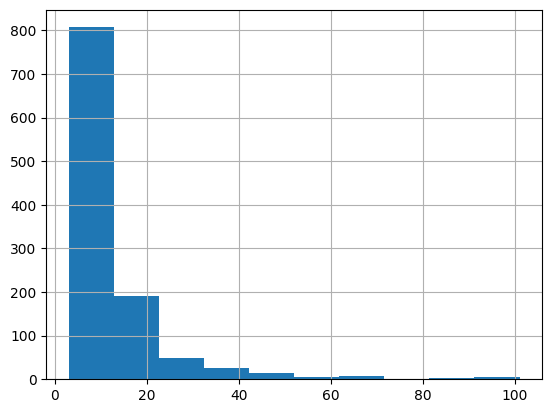

In [35]:
correct_samples["trajectory_length"].hist()